# Besoin Client 2

### Préparation des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Lire les données
df = pd.read_csv('./Data_Arbre.csv')

# Afficher les premières lignes du DataFrame pour comprendre sa structure
print(df.head())

   longitude   latitude              clc_quartier             clc_secteur  \
0   3.293264  49.840500  Quartier du Centre-Ville             Quai Gayant   
1   3.273380  49.861409    Quartier du Vermandois              Stade Cepy   
2   3.289068  49.844513  Quartier du Centre-Ville   Rue Villebois Mareuil   
3   3.302387  49.861778      Quartier de l'Europe  Square des Marronniers   
4   3.304047  49.858446      Quartier de l'Europe           Avenue Buffon   

   haut_tot  haut_tronc  tronc_diam fk_arb_etat fk_stadedev     fk_port  \
0       6.0         2.0        37.0    EN PLACE       Jeune  semi libre   
1      13.0         1.0       160.0    EN PLACE      Adulte  semi libre   
2      12.0         3.0       116.0    REMPLACÉ      Adulte  semi libre   
3      16.0         3.0       150.0    EN PLACE      Adulte  semi libre   
4       5.0         2.0       170.0    Essouché      Adulte      réduit   

  fk_pied fk_situation fk_revetement  age_estim  fk_prec_estim  clc_nbr_diag  \
0   ga

### On fait une table de corrélation sur toutes les valeurs pour déterminer quelles variables prendre pour déterminer age_estim

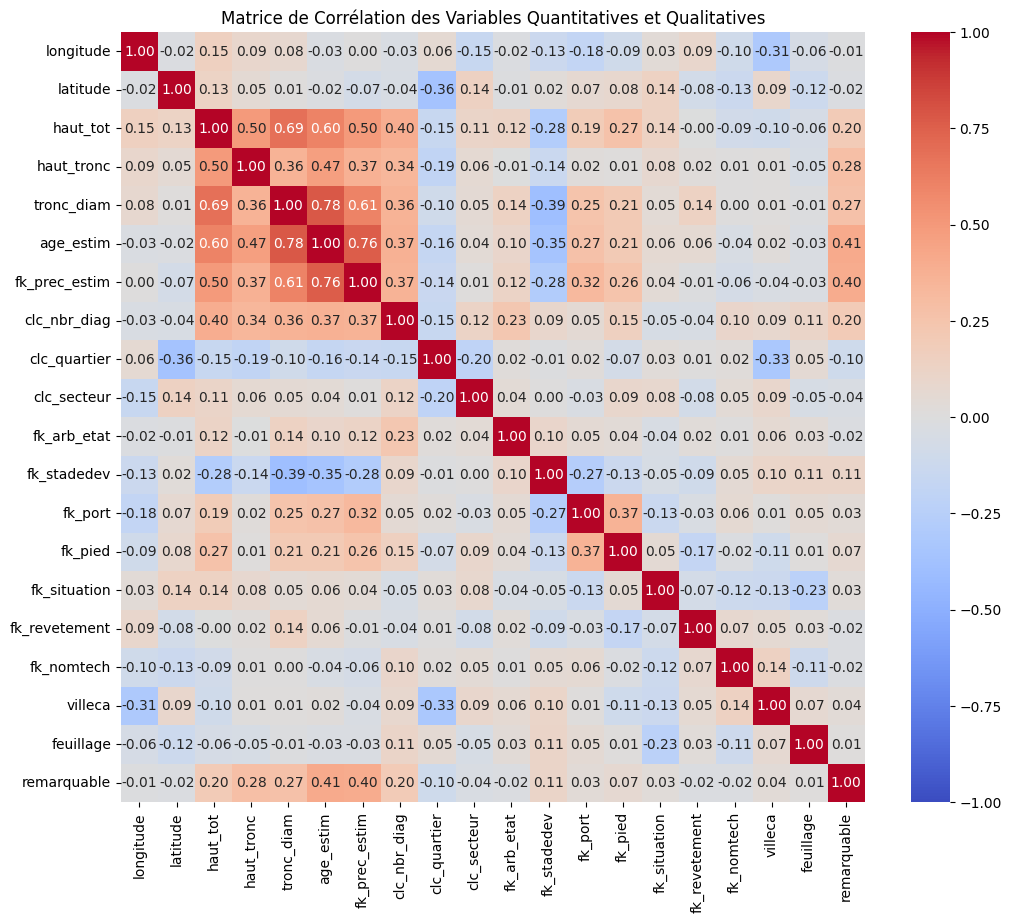

In [3]:
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

data = df

# Sélectionner les variables quantitatives
quantitative_vars = data.select_dtypes(include=['float64', 'int64'])

# Sélectionner et encoder les variables qualitatives
qualitative_vars = data.select_dtypes(include=['object', 'category']).apply(LabelEncoder().fit_transform)

# Combiner les variables quantitatives et qualitatives encodées
combined_vars = pd.concat([quantitative_vars, qualitative_vars], axis=1)

# Calculer la matrice de corrélation
correlation_matrix = combined_vars.corr()

# Afficher la matrice de corrélation
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Matrice de Corrélation des Variables Quantitatives et Qualitatives')
plt.show()


In [4]:
# Fonction pour filtrer les variables avec corrélation > 0.6 par rapport à age_estim
def filter_highly_correlated(corr_matrix, target_var, threshold=0.6):
    # Sélectionner les variables avec une corrélation absolue supérieure au seuil
    high_corr_vars = corr_matrix[target_var][abs(corr_matrix[target_var]) > threshold].index
    return high_corr_vars

In [5]:
# Variables fortement corrélées avec age_estim
high_corr_vars = filter_highly_correlated(correlation_matrix, 'age_estim',0.6)

# Afficher les variables fortement corrélées
print(f'Variables with correlation > 0.6 with age_estim: {list(high_corr_vars)}')

Variables with correlation > 0.6 with age_estim: ['haut_tot', 'tronc_diam', 'age_estim', 'fk_prec_estim']


On va prendre en compte toutes les variables qui ont une corrélation dites "forte" avec `age_estim`
On a donc les variables : `haut_tot`, `tronc_diam`, `fk_prec_estim`

In [6]:
# Sélectionner les colonnes pertinentes pour le clustering
data = df[['haut_tot','tronc_diam','fk_prec_estim','age_estim']]
data.head()

haut_tot  tronc_diam  fk_prec_estim  age_estim
0       6.0        37.0            5.0       15.0
1      13.0       160.0           10.0       50.0
2      12.0       116.0           10.0       30.0
3      16.0       150.0            2.0       50.0
4       5.0       170.0            2.0       40.0

### Apprentissage Supervisé

In [13]:
import joblib
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score

In [8]:
# Diviser la base de donnée en base de données d'apprentissage et une base de donnée test
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

In [15]:
# Définir les caractéristiques (X) et la cible (y)
X = data.drop('age_estim', axis=1)
y = data['age_estim'].values.reshape(-1, 1)

# Normalisation des données de X
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Normalisation de y avec MinMaxScaler
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Enregistrer le scaler de y
joblib.dump(scaler_y, 'scaler_y.pkl')
joblib.dump(scaler_X, 'scaler_X.pkl')

scores_regular = np.zeros(shape=(4,3))
scores_grid = np.zeros(shape=(4,3))

In [44]:
def getModelMetrics(model, X_train, X_test, y_train, y_test, name=str(), isGridSearch=False):
    # Entraîner le modèle
    model.fit(X_train, y_train.ravel())

    if isGridSearch:
        # Afficher les meilleurs paramètres et le meilleur score
        print(f'Best parameters for {name}:', model.best_params_)
        print(f'Best score for {name}:', model.best_score_)
    
        # Évaluation pour le meilleur modèle RandomForestRegressor
        model = model.best_estimator_
        filename = name.replace(' ', '_')
        joblib.dump(model, f'best_{filename}.pkl')

    # Prédictions sur les données de test
    y_pred_best_rf_scaled = model.predict(X_test)

    # Calcul des métriques de régression
    rmse = mean_squared_error(y_test, y_pred_best_rf_scaled, squared=False)
    mae = mean_absolute_error(y_test, y_pred_best_rf_scaled)
    r2 = r2_score(y_test, y_pred_best_rf_scaled)

    return [rmse, mae, r2]

def showMetrics(metrics):
    print(f'RMSE: {metrics[0]}')
    print(f'MAE: {metrics[1]}')
    print(f'R²: {metrics[2]}')

### Random Forest

In [35]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100 , random_state=42)
scores_regular[0] = getModelMetrics(model, X_train, X_test, y_train, y_test)
showMetrics(scores_regular[0])

RMSE: 0.04174427441262751
MAE: 0.02793589309154344
R²: 0.8172489454838877


/home/nicolas/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### GridSearch Random Forest 

In [45]:
# Définir la grille de paramètres pour GridSearchCV
param_grid = {
    'n_estimators': [50, 150, 250],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 15, 25],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 3, 5],
    'bootstrap': [True]
}
model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

scores_grid[0] = getModelMetrics(grid_search, X_train, X_test, y_train, y_test, 'Random Forest', True)
showMetrics(scores_grid[0])

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters for Random Forest: {'bootstrap': True, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 250}
Best score for Random Forest: 0.8271486554359122
RMSE: 0.040661377010300245
MAE: 0.02816148630671618
R²: 0.8266075343163487


/home/nicolas/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### KNN Regressor

In [46]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=5)
scores_regular[1] = getModelMetrics(model, X_train, X_test, y_train, y_test)
showMetrics(scores_regular[1])

RMSE: 0.04237709067131889
MAE: 0.028585695006747642
R²: 0.8116661721082419


/home/nicolas/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### GridSearch KNN Regressor

In [47]:
# Définir la grille de paramètres pour GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
model = KNeighborsRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

scores_grid[1] = getModelMetrics(grid_search, X_train, X_test, y_train, y_test, 'KNN Regressor', True)
showMetrics(scores_grid[1])

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for KNN Regressor: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}
Best score for KNN Regressor: 0.8247856500023729
RMSE: 0.04190599561010561
MAE: 0.02881732302784934
R²: 0.8158302135184735


/home/nicolas/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Bagging

In [48]:
from sklearn.ensemble import BaggingRegressor

model = BaggingRegressor(n_estimators=100, random_state=42)
scores_regular[2] = getModelMetrics(model, X_train, X_test, y_train, y_test)
showMetrics(scores_regular[2])

RMSE: 0.041857156519561914
MAE: 0.02794922720276931
R²: 0.8162592425080399


/home/nicolas/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### GridSearch Bagging

In [49]:
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False]
}
model = BaggingRegressor(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

scores_grid[2] = getModelMetrics(grid_search, X_train, X_test, y_train, y_test, 'Bagging', True)
showMetrics(scores_grid[2])

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for Bagging: {'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 100}
Best score for Bagging: 0.8252594385565484
RMSE: 0.04114036334772592
MAE: 0.02800962008153095
R²: 0.822498386846282


/home/nicolas/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Boosting

In [50]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(n_estimators=100, random_state=42)
scores_regular[3] = getModelMetrics(model, X_train, X_test, y_train, y_test)
showMetrics(scores_regular[3])

RMSE: 0.04246138381481367
MAE: 0.03165273270264435
R²: 0.8109161895577013


/home/nicolas/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### GridSearch Boosting

In [51]:
param_grid = {
    'n_estimators': [50, 150, 250],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [4, 6, 8],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2']
}
model = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

scores_grid[3] = getModelMetrics(grid_search, X_train, X_test, y_train, y_test, 'Boosting', True)
showMetrics(scores_grid[3])

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters for Boosting: {'learning_rate': 0.05, 'max_depth': 6, 'max_features': 'sqrt', 'n_estimators': 150, 'subsample': 0.9}
Best score for Boosting: 0.8392083141438332
RMSE: 0.040771563220381245
MAE: 0.0291981261437615
R²: 0.8256665260910871


/home/nicolas/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Comparaison des résultats (avec GridSearch)

[[0.04066138 0.02816149 0.82660753]
 [0.041906   0.02881732 0.81583021]
 [0.04114036 0.02800962 0.82249839]
 [0.04077156 0.02919813 0.82566653]]


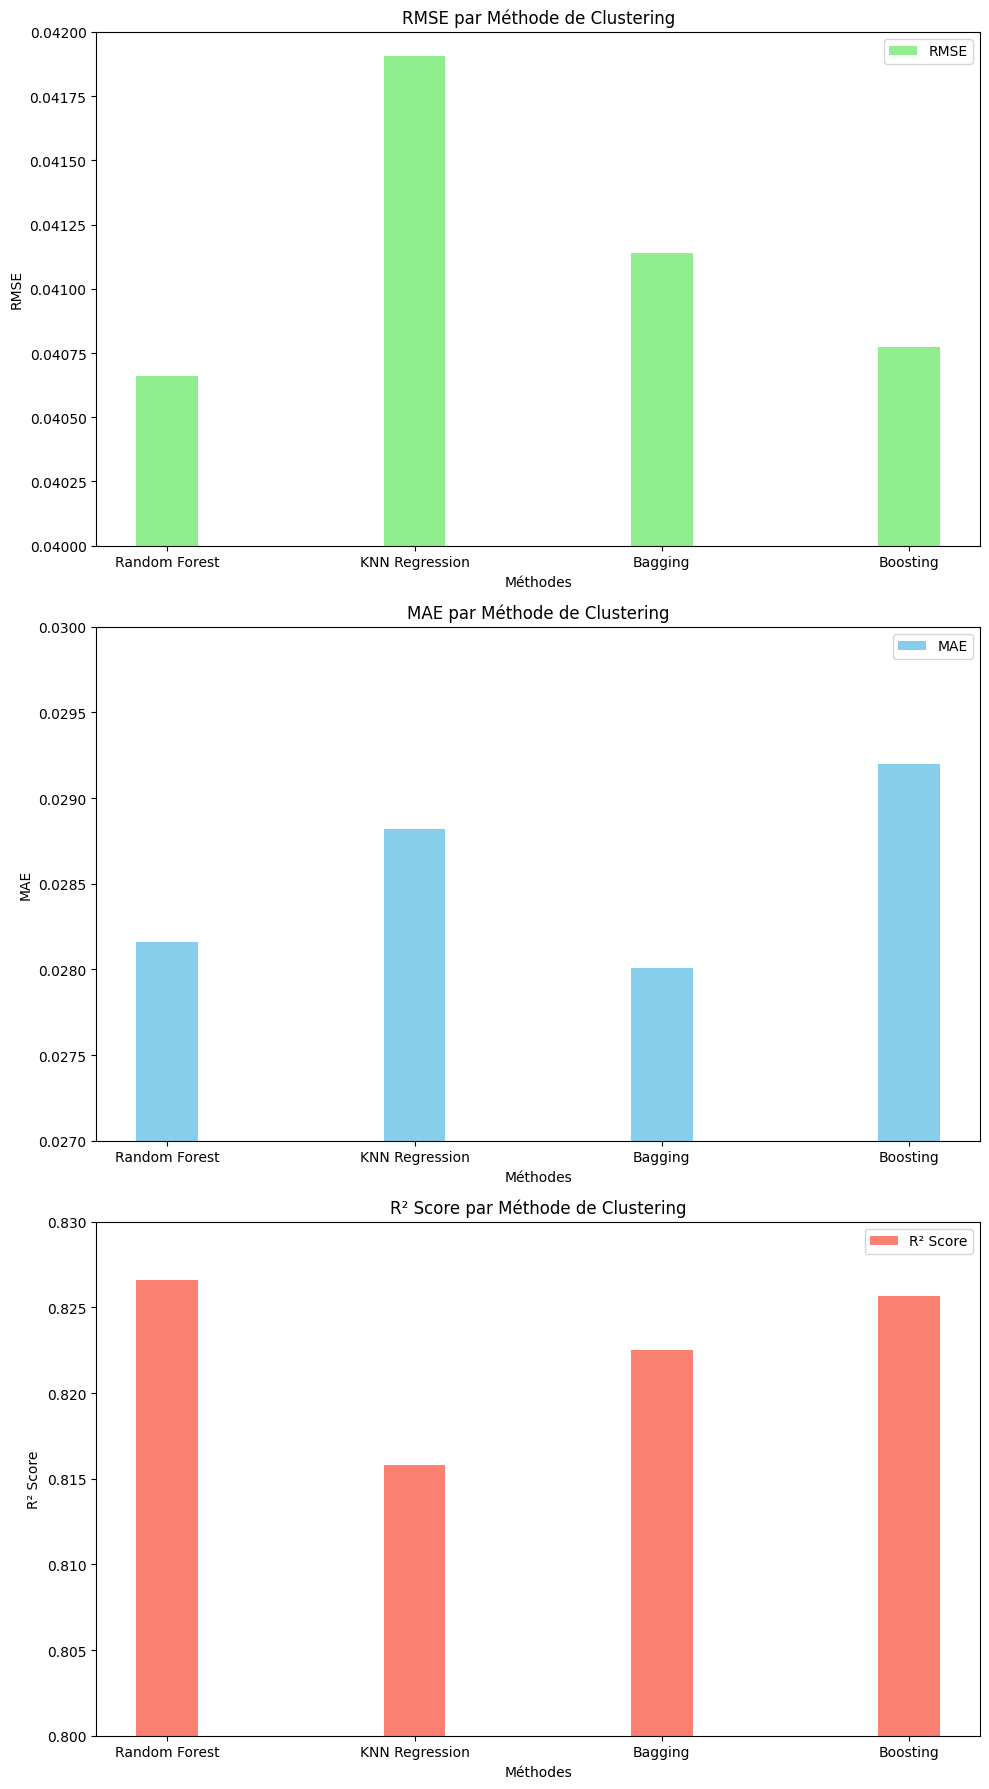

In [54]:
import matplotlib.pyplot as plt


# Les résultats des métriques pour chaque méthode
methods = ['Random Forest', 'KNN Regression', 'Bagging', 'Boosting']

RMSE = scores_grid[:,0]
MAE = scores_grid[:,1]
R2 = scores_grid[:,2]

# Définir la position des barres
x = np.arange(len(methods))

# Largeur des barres
width = 0.25

# Créer une figure avec trois sous-graphiques
fig, axs = plt.subplots(3, 1, figsize=(10, 18))

# Deuxième graphique pour RMSE
axs[0].bar(x, RMSE, width, label='RMSE', color='lightgreen')
axs[0].set_xlabel('Méthodes')
axs[0].set_ylabel('RMSE')
axs[0].set_ylim([0.040, 0.042])
axs[0].set_title('RMSE par Méthode de Clustering')
axs[0].set_xticks(x)
axs[0].set_xticklabels(methods)
axs[0].legend()

# Premier graphique pour MAE Score
axs[1].bar(x, MAE, width, label='MAE', color='skyblue')
axs[1].set_xlabel('Méthodes')
axs[1].set_ylabel('MAE')
axs[1].set_ylim([0.027, 0.030])
axs[1].set_title('MAE par Méthode de Clustering')
axs[1].set_xticks(x)
axs[1].set_xticklabels(methods)
axs[1].legend()

# Troisième graphique pour R² Score
axs[2].bar(x, R2, width, label='R² Score', color='salmon')
axs[2].set_xlabel('Méthodes')
axs[2].set_ylabel('R² Score')
axs[2].set_ylim([0.80, 0.83])
axs[2].set_title('R² Score par Méthode de Clustering')
axs[2].set_xticks(x)
axs[2].set_xticklabels(methods)
axs[2].legend()

# Ajuster la mise en page
plt.tight_layout()
plt.show()

Pour le MAE et le RSME on souhaite obtenir les valeur les plus faible possible, 
Random Forest possède le RSME le plus faible
Bagging possède le MAE le plus faible
Pour le R² on souhaite obtenir la valeiur la plus proche de 1, la valeur la plus proche de 1 est Random Forest.


Random Forest étant le meilleur dans deux des trois tests observés, sachant qu'il est le deuxième meilleur modèle pour le MAE.
On peut donc dire que le meilleur modèle est Random Forest